In [1]:
import os.path
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset, load_model_, save_model

[2024-05-11 00:32:49,287] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
from utilites import *#draw_heatmap, MyLabelEncoder, add_spaces, balance_majority

In [4]:

#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [29]:
vdjdb = pd.read_csv('../data/vdjdb_full.txt', sep='\t', low_memory=False)

In [30]:
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02:01,HLA-A*24:02;HLA-B*08:01,HLA-B*5701...",NaN,NaN,"{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,NaN,"{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02,HLA-A*24:02;HLA-B*08:01,HLA-B*15;HLA-...",NaN,NaN,"{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2


In [31]:
vdjdb.columns

Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope',
       'antigen.gene', 'antigen.species', 'reference.id',
       'method.identification', 'method.frequency', 'method.singlecell',
       'method.sequencing', 'method.verification', 'meta.study.id',
       'meta.cell.subset', 'meta.subject.cohort', 'meta.subject.id',
       'meta.replica.id', 'meta.clone.id', 'meta.epitope.id', 'meta.tissue',
       'meta.donor.MHC', 'meta.donor.MHC.method', 'meta.structure.id',
       'cdr3fix.alpha', 'cdr3fix.beta', 'vdjdb.score'],
      dtype='object')

In [32]:
vdjb_short = vdjdb[['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'antigen.epitope', 'mhc.class']]
vdjb_short.shape

(62177, 9)

In [33]:
vdjb_short = vdjb_short[vdjb_short['antigen.epitope'] != 'KLGGALQAK']
vdjb_short.shape

(48203, 9)

In [34]:
le = MyLabelEncoder()
groups = vdjb_short['antigen.epitope'].value_counts().index

le.fit(groups)
groups
le.transform(groups)

array([   0,    1,    2, ..., 1165, 1166, 1167])

In [35]:
vdjb_short['antigen.epitope'].value_counts()[vdjb_short['antigen.epitope'].value_counts()>500].shape[0]

19

In [36]:
vdjb_short['antigen.epitope']= le.transform(vdjb_short['antigen.epitope'])
vdjb_short

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,antigen.epitope,mhc.class
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,37,MHCI
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,37,MHCI
...,...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,131,MHCII
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,NaN,TRBJ2-3*01,131,MHCII
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,NaN,TRBJ2-1*01,244,MHCII
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,NaN,TRBJ2-5*01,244,MHCII


In [37]:
vdjb_short = vdjb_short[vdjb_short['antigen.epitope']<19]

<BarContainer object of 19 artists>

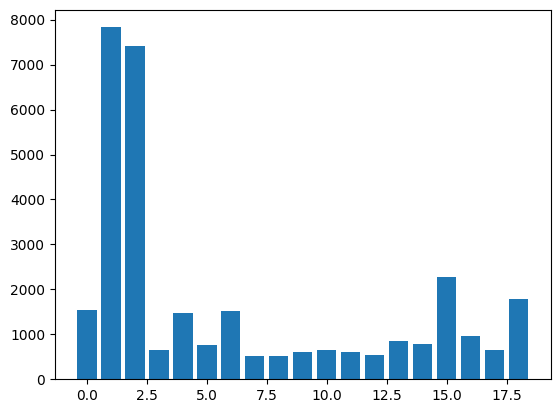

In [38]:
plt.bar(vdjb_short['antigen.epitope'].unique(), vdjb_short['antigen.epitope'].value_counts())

In [39]:
vdjb_short[['cdr3.alpha', 'cdr3.beta', 'antigen.epitope']]

,cdr3.alpha,cdr3.beta,antigen.epitope
385,NaN,CASSPQTGTGGYGYTF,1
386,NaN,CASSPQTGTGGYGYTF,1
387,NaN,CASSPLFGTSGGETYYF,1
388,NaN,CASSPQTGTGGYGYTF,1
389,NaN,CASSPQTGASYGYTF,1
...,...,...,...
61810,CAGLNYGGSQGNLIF,CASSWRQGGSIRESYTF,17
61811,NaN,CASSLSSGWPYGYTF,17
61812,CAALNYGGSQGNLIF,CASSDRGTGLNGYTF,17
61813,CAGLNYGGSQGNLIF,CASGPGGMTEAFF,17


In [40]:
vdjb_short = vdjb_short.fillna('')
vdjb_short['cdr3aa'] = vdjb_short['cdr3.alpha'] + vdjb_short['cdr3.beta'].apply(lambda s: s[::-1])
vdjb_short.shape

(31957, 10)

In [41]:
vdjb_cdr = vdjb_short[['cdr3aa', 'antigen.epitope']]

In [42]:
vdjb_cdr

,cdr3aa,antigen.epitope
385,FTYGYGGTGTQPSSAC,1
386,FTYGYGGTGTQPSSAC,1
387,FYYTEGGSTGFLPSSAC,1
388,FTYGYGGTGTQPSSAC,1
389,FTYGYSAGTQPSSAC,1
...,...,...
61810,CAGLNYGGSQGNLIFFTYSERISGGQRWSSAC,17
61811,FTYGYPWGSSLSSAC,17
61812,CAALNYGGSQGNLIFFTYGNLGTGRDSSAC,17
61813,CAGLNYGGSQGNLIFFFAETMGGPGSAC,17


In [43]:
# vdjb_cdr.dropna(inplace=True)
vdjb_cdr.reset_index(inplace=True, drop=True)

In [44]:
vdjb_cdr

,cdr3aa,antigen.epitope
0,FTYGYGGTGTQPSSAC,1
1,FTYGYGGTGTQPSSAC,1
2,FYYTEGGSTGFLPSSAC,1
3,FTYGYGGTGTQPSSAC,1
4,FTYGYSAGTQPSSAC,1
...,...,...
31952,CAGLNYGGSQGNLIFFTYSERISGGQRWSSAC,17
31953,FTYGYPWGSSLSSAC,17
31954,CAALNYGGSQGNLIFFTYGNLGTGRDSSAC,17
31955,CAGLNYGGSQGNLIFFFAETMGGPGSAC,17


In [45]:
vdjb_cdr['antigen.epitope'].value_counts()

0     7830
1     7416
2     2284
3     1782
4     1536
5     1521
6     1485
7      960
8      847
9      780
10     757
11     661
12     653
13     651
14     612
15     600
16     542
17     526
18     514
Name: antigen.epitope, dtype: int64

In [46]:
vdjb_cdr = balance_majority(vdjb_cdr, 'antigen.epitope', min_count=90, max_count=1550)

In [47]:
test_dataset = vdjb_cdr.sample(frac=0.125, random_state=42)
vdjb_cdr_train = vdjb_cdr.drop(test_dataset.index)

In [48]:
vdjb_cdr_train['cdr3aa'] = vdjb_cdr_train['cdr3aa'].apply(add_spaces)
test_dataset['cdr3aa'] = test_dataset['cdr3aa'].apply(add_spaces)


In [49]:
ans = test_dataset['antigen.epitope']
test_dataset = test_dataset.drop(columns=['antigen.epitope'])



In [25]:
N_LABELS = vdjb_cdr['antigen.epitope'].nunique()
epit_mod = CustomModel(n_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([19, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
vdjb_cdr_train = vdjb_cdr_train.reset_index(drop=True)
vdjb_cdr_train

,cdr3aa,antigen.epitope
0,C A V N R D D K I I F F Y Q E I D P S S A C,4
1,C V V N R N N D M R F F F L E G T N T V Q G A C,4
2,C A V N R D D K I I F F Y Q E I D P S S A C,4
3,F F L E G T N Q G V H D R A S C,4
4,F F L E G S I G F S S A C,4
...,...,...
16956,C I L R D P G R N G G S Q G N L I F F H Q P Q ...,3
16957,C A V N G N N A R L M F F Y Q T D T T I V G S ...,3
16958,F F L K E R A G R N L S S A C,3
16959,C A V S D R G Y N K L I F F F A E T E E E F S ...,3


In [28]:
input_ids, attention_masks, labels = epit_mod.tokenize(vdjb_cdr_train['cdr3aa'], vdjb_cdr_train['antigen.epitope'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
train_dataset, val_dataset = epit_mod.split_data(input_ids, attention_masks, labels)

13,568 training samples
3,393 validation samples


In [30]:
# epit_alpha_mod.tokenizer.pad_token = epit_alpha_mod.tokenizer.eos_token

In [31]:
epit_mod.fit(train_dataset, val_dataset, epochs=7)


======== Epoch 1 / 7 ========
Training...

  Average training loss: 1.83
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.51
  Validation Loss: 1.53
  Validation took: 0:00:02

======== Epoch 2 / 7 ========
Training...

  Average training loss: 1.43
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.53
  Validation Loss: 1.48
  Validation took: 0:00:02

======== Epoch 3 / 7 ========
Training...

  Average training loss: 1.21
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.40
  Validation took: 0:00:02

======== Epoch 4 / 7 ========
Training...

  Average training loss: 1.02
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.40
  Validation took: 0:00:02

======== Epoch 5 / 7 ========
Training...

  Average training loss: 0.84
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.41
  Validation took: 0:00:02

======== Epoch 6 / 

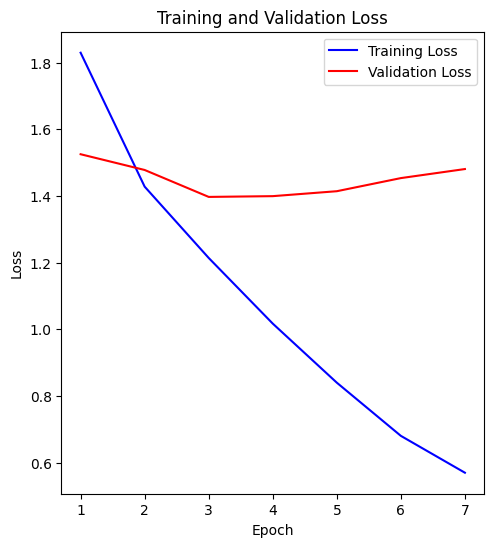

In [32]:
epit_mod.draw_stats_plot()

In [50]:
# from my_model import save_model
# save_model(epit_mod, '../models_ft/tcr_epit.pth')

epit_model = load_model_('../models_ft/tcr_epit.pth', mod_type='TCR-bert', num_labels= N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([19, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
epit_model.maximun_len =45
epit_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [52]:
pred_labels = epit_model.predict(test_dataset['cdr3aa'])
f1_sc_tcr = f1_score(ans, pred_labels, average='macro')
print('Total f1_score: %.5f' % f1_sc_tcr)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.63921


In [36]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [53]:
hid_sts = []
lbls = []
hid_sts_long = []

draw_data = balance_majority(vdjb_cdr_train, 'antigen.epitope', max_count=500)
epit_model.to(device)

for seq in tqdm(draw_data.index):
    seq, lab = draw_data.loc[seq]#.to(device)
    en_dict = epit_model.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 45, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
   
    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
   
    with torch.no_grad():
        outputs = epit_model.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    lbls.append(lab)
    # emb = torch.mean(torch.mean(torch.stack(list(outputs.hidden_states), dim=2), dim = 0))
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/9380 [00:00<?, ?it/s]/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 9380/9380 [01:40<00:00, 93.15it/s]


In [38]:
import umap
import umap.plot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot: >

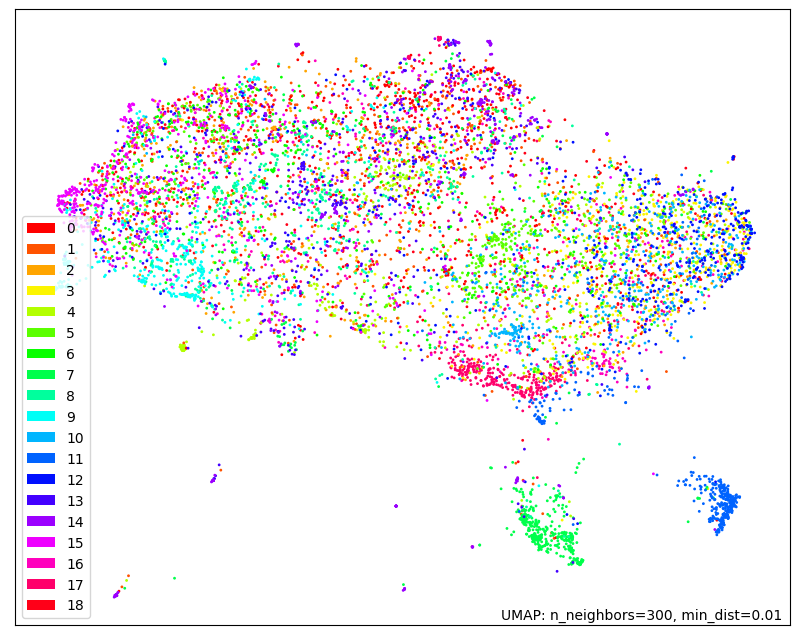

In [39]:
reduced = umap.UMAP(n_neighbors=300, min_dist=0.01).fit(hid_sts)

umap.plot.points(reduced, labels=np.array(lbls), color_key_cmap='hsv', width=1000)


In [54]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/scratch/ipykernel_2335271/2416037138.py:9: UserWarning: The palette list has more values (21) than needed (19), which may not be intended.
  sns.scatterplot(


Text(0.5, 1.0, 'Embeddings colored by the predicted epitope')

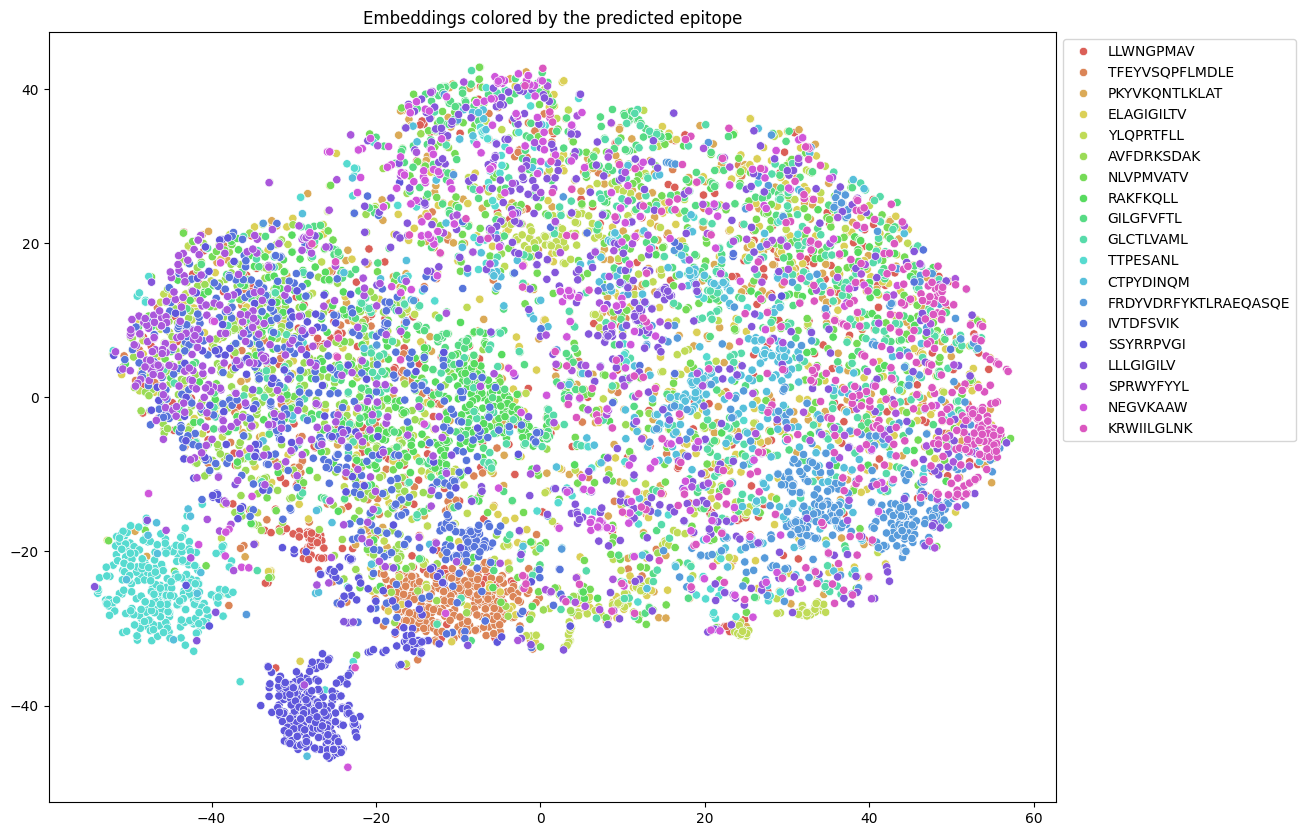

In [56]:
# pca = PCA(n_components=8)#(hid_sts)
# pca_embedding = pca.fit_transform(hid_sts)



# tsne = TSNE(n_components=2, n_iter=900, perplexity=100, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
# tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(13,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=le.inverse_transform(lbls),
    palette=sns.color_palette("hls", 21),
    legend="full",
    alpha=1
)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Embeddings colored by the predicted epitope')

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 9380 samples in 0.002s...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f4c64e7dd30>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[t-SNE] Computed neighbors for 9380 samples in 0.707s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9380
[t-SNE] Computed conditional probabilities for sample 2000 / 9380
[t-SNE] Computed conditional probabilities for sample 3000 / 9380
[t-SNE] Computed conditional probabilities for sample 4000 / 9380
[t-SNE] Computed conditional probabilities for sample 5000 / 9380
[t-SNE] Computed conditional probabilities for sample 6000 / 9380
[t-SNE] Computed conditional probabilities for sample 7000 / 9380
[t-SNE] Computed conditional probabilities for sample 8000 / 9380
[t-SNE] Computed conditional probabilities for sample 9000 / 9380
[t-SNE] Computed conditional probabilities for sample 9380 / 9380
[t-SNE] Mean sigma: 2.045267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.345428
[t-SNE] KL divergence after 500 iterations: 1.707028


/scratch/ipykernel_2335271/3495003357.py:9: UserWarning: The palette list has more values (21) than needed (19), which may not be intended.
  sns.scatterplot(


Text(0.5, 1.0, 'Embeddings colored by the predicted epitope')

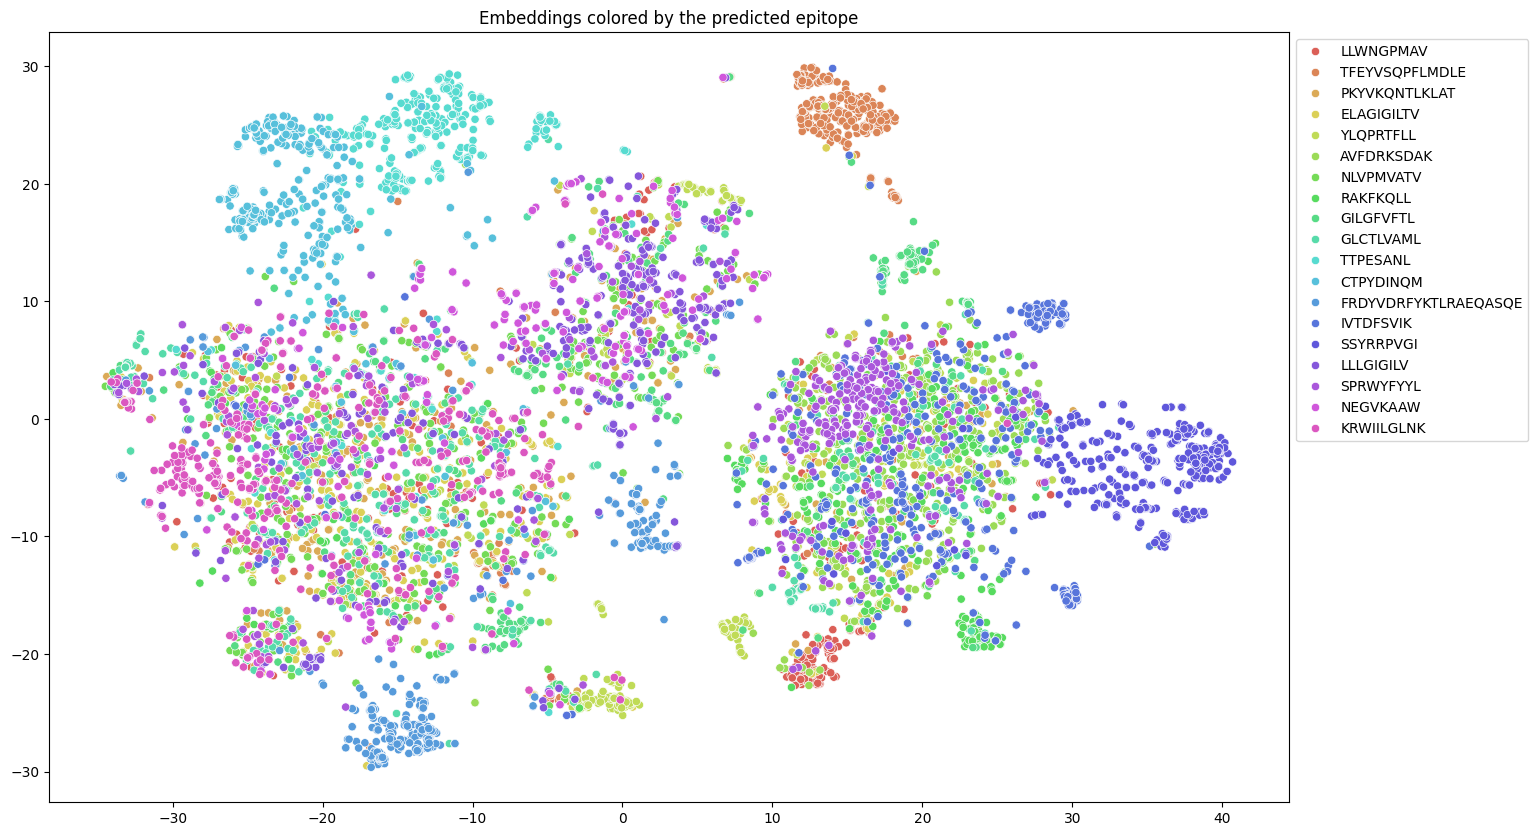

In [57]:
# pca = PCA(n_components=50)#(hid_sts)
# pca_embedding = pca.fit_transform(hid_sts_long)



# tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
# tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(13,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=le.inverse_transform(lbls),
    palette=sns.color_palette("hls", 21),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Embeddings colored by the predicted epitope')

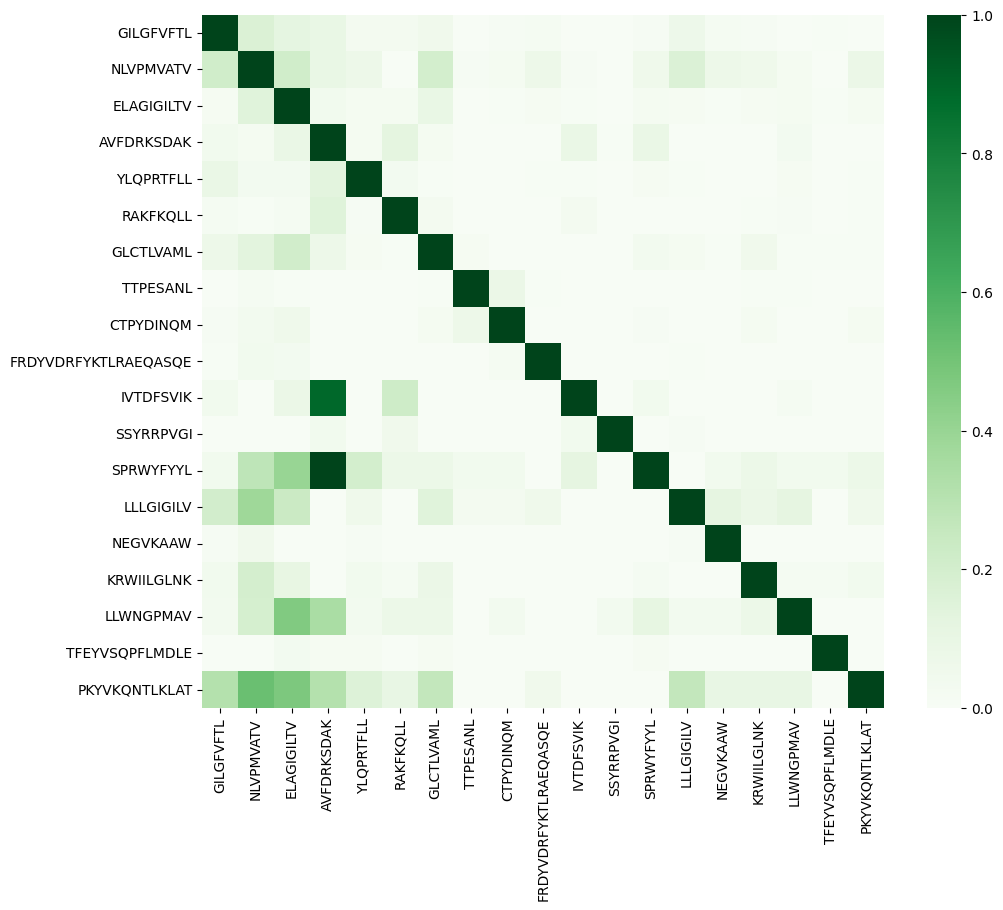

In [58]:
draw_heatmap(pred_labels, ans, le, n_cl=N_LABELS, return_mtr = False)

### Prottrans

In [45]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(vdjb_cdr_train, test_size=0.2, random_state=42)

In [46]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'antigen.epitope': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'antigen.epitope': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
3477,C A E S T G K L I F F F L K E N T G G T G V S C,6
13144,F T Y G Y A A G T Q Y S S A C,1
1688,C A V R D I R D N F N K F Y F F Y Q E Y L D G ...,5
1456,F F A E T N V S T T Q S S A C,5
10434,F Y Q E Y A G V D V S C,16
...,...,...
8904,C A V S N Y Q L I W,14
5999,F Y Q T D G G S A R H S S A C,9
8093,F Y Q I N K A L P G G A I L S S A C,12
7234,C A T D A D N N N A P R F F T Y D S N S S S A C,11


In [47]:
N_LABELS = vdjb_cdr['antigen.epitope'].nunique()

tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=N_LABELS, batch=32, accum=8, epochs=13, seed=42)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.6.layer.1.layer_norm.weight', 'decoder.block.20.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.21.layer.1.EncDecAttention.k.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.12.layer.0.SelfAttention.q.weight', 'decoder.block.12.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.20.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.16.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.1.EncDec

ProtT5_Classfier
Trainable Parameter: 1209210899
ProtT5_LoRA_Classfier
Trainable Parameter: 3576851

[2024-05-09 21:40:51,283] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-09 21:40:51,284] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2024-05-09 21:40:51,324] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.14.0, git-hash=unknown, git-branch=unknown
[2024-05-09 21:40:53,415] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadl

Using /home/akabalina/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Detected CUDA files, patching ldflags
Emitting ninja build file /home/akabalina/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ninja: no work to do.
Time to load cpu_adam op: 3.976714611053467 seconds
[2024-05-09 21:41:01,678] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer


Loading extension module cpu_adam...


[2024-05-09 21:41:01,680] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-09 21:41:01,726] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-09 21:41:01,726] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-09 21:41:01,727] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2024-05-09 21:41:01,727] [INFO] [stage_1_and_2.py:149:__init__] Reduce bucket size 200000000
[2024-05-09 21:41:01,728] [INFO] [stage_1_and_2.py:150:__init__] Allgather bucket size 200000000
[2024-05-09 21:41:01,728] [INFO] [stage_1_and_2.py:151:__init__] CPU Offload: True
[2024-05-09 21:41:01,729] [INFO] [stage_1_and_2.py:152:__init__] Round robin gradient partitioning: False
Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alp

***** Running training *****
  Num examples = 13568
  Num Epochs = 13
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 8
  Total optimization steps = 689
  Number of trainable parameters = 3576851


Epoch,Training Loss,Validation Loss,Accuracy
1,2.610600,2.369242,0.251695
2,2.155200,2.062723,0.348659
3,1.891200,1.856189,0.407014
4,1.750400,1.777245,0.433834
5,1.661200,1.701354,0.457707
6,1.589700,1.631175,0.477454
7,1.534000,1.599132,0.489537
8,1.481200,1.570608,0.507221
9,1.437000,1.555439,0.503095
10,1.396700,1.530507,0.514294


***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3393
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/mod

In [48]:
# tokenizer, model = load_model_('../models_ft/prottrans_epit.pth', num_labels=N_LABELS)

In [49]:
test_set=create_dataset(tokenizer, list(test_dataset['cdr3aa']),list(ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)


model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 236/236 [00:21<00:00, 11.14it/s]


In [50]:
predictions= [item.argmax() for item in np.array(predictions)]
f1_prottr = f1_score(list(ans), predictions, average='macro')
print("F1 score: ", f1_prottr)

F1 score:  0.5449984590687235


In [51]:
save_model(model, '../models_ft/prottrans_epit.pth')

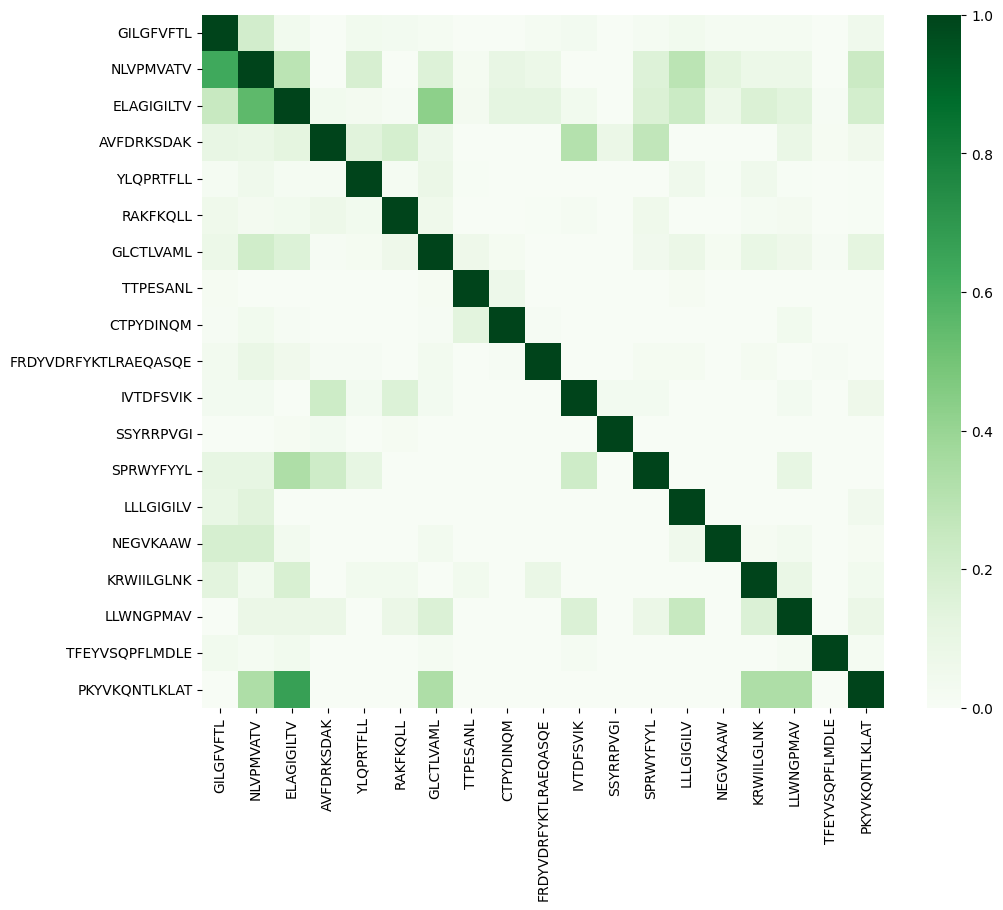

In [53]:
draw_heatmap(ans, predictions, le, N_LABELS, return_mtr=False)